# Statistiques Descriptives - Panne de pièces 

**objectif** : 
- manipulation de données via Pandas 
- répondre à une problématique on s'appuyant sur des données 

### Introduction 
Le fabriquant d’un système mécanique propose une garantie associée à son produit. Pendant une
période d’exploitation il a fait évoluer son matériel et a distribué trois types de versions de ce
produit. Pendant cette même période il a observé une série de pannes qui ont conduit à des retours
en atelier pour réparation ou échange. Ces interventions sont à sa charge tant que dure la garantie, il
cherche donc à optimiser son appareil en identifiant les éléments les plus impactant. 

**Problématique : Comment déterminer les composants qui peuvent le plus poser problème ?**

On découpera cet exercice de la manière suivante :    
La première partie se concentrera sur l'exploration de nos jeu de données, on va chercher à comprendre notre jeu de données, vérifier qu'il est propre et si ce n'est pas le cas, le nettoyer. 

La seconde partie quand à elle se compose en la recherche de relations entre des variables qui nous semblent pertinentes ainsi que des modèles que l'on pourrait poser sur ces relations ou pouvoir donner les tendances de nos relations. 

Finalement nous conclurons en donnant les composants qui nous semblent poser le plus de problèmes, expliquer pourquoi en récapitulant ce qui a été fais ainsi que d'expliquer les limites de ce que l'on a fais.

# I - Exploration des datasets 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

On a à disposition deux dataframes, facteur et cout que nous allons étudier plus loin

In [2]:
facteur = pd.read_excel(io ='data_exercice.xlsx', sheet_name = 'Facteurs')
cout = pd.read_excel(io = 'data_exercice.xlsx', sheet_name = 'Cout')

## I.1) Exploration du dataframe facteur

In [3]:
facteur.head()

,Id,Version,D1,D2,Panne,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,348606,v3,13665.09,11751.56,G,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,348762,v2,4888.38,3944.48,A,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,348855,v1,10273.96,13592.97,A,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0
3,348906,v2,2149.26,3965.84,C,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,348946,v3,1.13,6.23,D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### description du dataframe
- Id : identifiant de la pièce (supposé unique !)
- Version : version de la pièce (3 versions possible : v1,v2,v3)
- D1 & D2 : durée de fonctionnement pour les deux modes de fonctionnement de l'appareil
- Panne : type de panne (A à I)
- X1, ... X15 : les diagnostiques    
    - le diagnostique Xk correspond à un problème sur le composant k    
    => par abus de notation, on parlera du composant k pour parler du diagnostique Xk

In [4]:
print("shape du dataframe {}".format(facteur.shape))

shape du dataframe (461, 20)


On sait ce que l'on est censé avoir dans notre dataframe, maintenant on peut se demander s'il ne nous manque pas certaines données ou si certaines données sont en doubles etc.

### I.1.1) nettoyage du dataframe facteur 

Regardons d'abord si nous n'avons pas des valeurs en double etc. 

In [5]:
duplica = facteur.duplicated().sum()
if duplica > 1:
    print("Il y'a {} éléments en double".format(facteur.duplicated().sum()))
else:
    print("Il y'a {} élément en double".format(facteur.duplicated().sum()))


Il y'a 0 élément en double


Maintenant qu'on sait qu'il n'y'a pas de doublons, on peut se demander s'il y'a des valeurs aberrantes ou manquantes. 
On considère que les valeurs aberrantes sont les cas où on aurait une panne / problème d'une pièce alors qu'on ne l'a jamais utilisé (donc D1 = D2 = 0)

In [6]:
duplica = facteur[(facteur['D1'] == 0) & (facteur['D2'] == 0)]

In [7]:
duplica.head()

,Id,Version,D1,D2,Panne,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
392,387538,v3,0.0,0.0,E,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
422,390634,v1,0.0,0.0,E,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
print("shape avant drop : {}".format(facteur.shape))
facteur = facteur.drop(duplica.index)
print("shape du dataframe {}".format(facteur.shape))

shape avant drop : (461, 20)
shape du dataframe (459, 20)


Maintenant on peut regarder les cas où l'on aurait des pannes mais que l'on aurait pas eu de diagnostique pour au moins un composant. 

In [9]:
liste_features = facteur.columns.tolist()

test_compo = list(map(lambda txt: txt.startswith('X'), liste_features))

liste_compo = []
for i in range(len(liste_features)):
    if test_compo[i] == True:
        liste_compo.append(liste_features[i])
        
df_compo = facteur[liste_compo]

In [10]:
df_compo.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
somme_diag = df_compo.sum(axis = 1)
pas_de_diag = somme_diag.index[somme_diag.values == 0].tolist()

facteur = facteur.drop(pas_de_diag) 

In [12]:
print("On a donc {} cas de pièces défectueuses pour {} pièces uniques".format(facteur.shape[0], len(facteur['Id'].unique())))

On a donc 444 cas de pièces défectueuses pour 434 pièces uniques


### I.1.2) nettoyage du dataframe cout

In [13]:
cout.head()

,Id,Panne,Cout
0,349483,A,15.84
1,350021,D,19.14
2,350212,B,9.90
3,351351,F,4.40
4,351351,F,28.16


#### description du dataframe
- Id : identifiant de la pièce (supposé unique !)
- Panne : type de panne (A à I)
- Cout : cout de réparation de la panne    

On peut commencer par se dire que si notre cout de réparation est nul, c'est qu'il y'a un problème. Il y'a forcément quelque chose à réparer etc. donc on a besoin d'un minimum d'argent. Les cas où on a un cout nul peuvent donc être considérés comme aberrant.

In [14]:
cout_nul = cout[cout['Cout'] == 0]

In [15]:
cout_nul.head()

,Id,Panne,Cout
10,354517,E,0.0
49,369558,E,0.0
96,387694,D,0.0
100,388446,D,0.0


In [16]:
print("shape de count avant drop : {}".format(cout.shape))
cout = cout.drop(cout_nul.index)
print("shape de count après drop : {}".format(cout.shape))

shape de count avant drop : (109, 3)
shape de count après drop : (105, 3)


### I.2) Recherche d'informations dans le dataframe facteur

In [17]:
Occurence_Panne = facteur['Panne'].value_counts()
Occurence_Panne

A    224
F     60
G     50
E     31
D     30
C     20
I     14
B      9
H      6
Name: Panne, dtype: int64

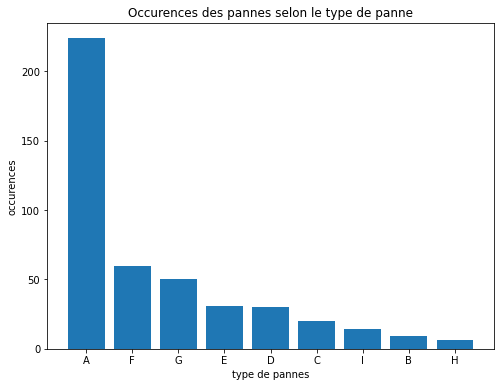

In [18]:
fig_panne,ax_panne = plt.subplots(figsize=(8,6))
plt.bar(np.arange(Occurence_Panne.size),Occurence_Panne, tick_label = Occurence_Panne.index.tolist())
plt.title("Occurences des pannes selon le type de panne")
plt.xlabel("type de pannes")
plt.ylabel("occurences")
plt.show()

Déjà on se rend compte qu'un type de panne (la panne A) représente la majorité des pannes.

On peut aussi se demander quels composants (X1,...,X15) tombe le plus souvent en panne.

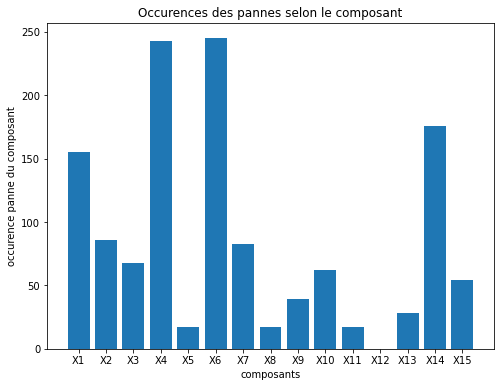

In [19]:
fig_panne_comp,ax_panne_comp = plt.subplots(figsize=(8,6))
plt.bar(np.arange(df_compo.sum(axis = 0).size),df_compo.sum(axis = 0), tick_label = df_compo.columns.tolist())
plt.title("Occurences des pannes selon le composant")
plt.xlabel("composants")
plt.ylabel("occurence panne du composant")
plt.show()

On remarque que la répartition des pannes de composants n'est pas du tout uniforme. En effet X4 et X6 dominent largement suivi de X14 et X1. De plus il n'y'a aucun cas de pannes pour X12. on pourrait donc déjà recommander au fabriquant de s'intéresser à pourquoi ces composants en particulier tombent en panne.

Maintenant on peut aussi se demander quel est l'impact de la version de la pièce sur le nombre d'occurences des pannes

In [20]:
# On crée les df composés uniquement des mêmes versions
facteur_v1 = facteur[facteur['Version'] == 'v1']
facteur_v2 = facteur[facteur['Version'] == 'v2']
facteur_v3 = facteur[facteur['Version'] == 'v3']

# on ne considère que les diagnostiques pour ces versions
facteur_v1 = facteur_v1[liste_compo]
facteur_v2 = facteur_v2[liste_compo]
facteur_v3 = facteur_v3[liste_compo]

# pour chaque version on fait la somme pour obtenir le nombre de cas de panne par diagnostique
facteur_v1 = facteur_v1.sum(axis=0)
facteur_v2 = facteur_v2.sum(axis=0)
facteur_v3 = facteur_v3.sum(axis=0)

In [21]:
facteur_v2.head()

X1     4
X2     2
X3     3
X4    12
X5     0
dtype: int64

In [22]:
df_facteur_versions= pd.concat([facteur_v1.rename('v1'), facteur_v2.rename('v2'), facteur_v3.rename('v3')], axis=1)

In [23]:
df_facteur_versions.head()

,v1,v2,v3
X1,91,4,60
X2,46,2,38
X3,41,3,24
X4,143,12,88
X5,10,0,7


In [24]:
for val in df_facteur_versions.columns.tolist():
    print("Pour la version : {}, on a {} occurences de pannes".format(val,df_facteur_versions[val].sum(axis =0)))

Pour la version : v1, on a 772 occurences de pannes
Pour la version : v2, on a 49 occurences de pannes
Pour la version : v3, on a 469 occurences de pannes


Text(0.5, 1.0, 'Occurences totales')

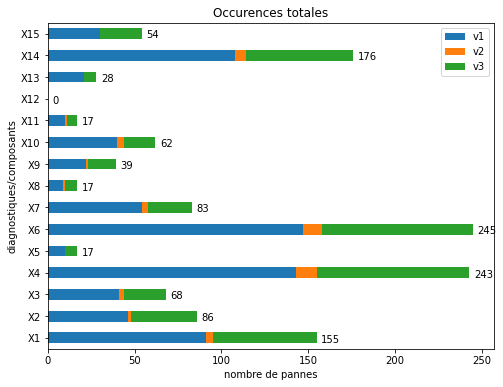

In [25]:
ax_oc = df_facteur_versions.plot.barh(stacked=True, figsize = (8,6))
for i, v in enumerate(df_facteur_versions.sum(axis=1)):
    ax_oc.text(v + 2.5, i-0.2 , str(v))
    
ax_oc.set_xlabel("nombre de pannes")
ax_oc.set_ylabel("diagnostiques/composants")
ax_oc.set_title("Occurences totales")

On remarque que la v1 des pièces est celle qui engendre le plus de pannes. la version v2 le minimum et la version v3 l'entre deux. Toutefois ce raisonnement est très vite limité car certes on connaît le nombre de pannes pour chaque versions mais pas le nombre total de pièces. Il y'a peut-être eu 1 million de pièces v1 60 pièces v2 et 800 pièces v3 au total.    
N'ayant pas le numéro du fabricant, nous ne pourrons pas obtenir cette information. On ne peut donc à priori pas dire grand chose de plus que par rapport à un graphique précédent.

### I.3)  Création d'un dataframe "augmenté"

Le gros problème du dataframe coût est que si on le considère seul, on a très peu d'informations.

In [26]:
cout.head()

,Id,Panne,Cout
0,349483,A,15.84
1,350021,D,19.14
2,350212,B,9.90
3,351351,F,4.40
4,351351,F,28.16


On va donc plutôt considérer un dataframe "augmenté". En effet comme on peut se servir d'Id et de Panne comme des identifiants uniques, on peut trouver dans le dataframe facteur les élements dont les coûts sont recensés dans le dataframe coût. On va donc pouvoir en extraire des informations en plus.

In [27]:
facteur_cout_commun = pd.merge(facteur, cout, how ='inner', on =['Id', 'Panne'])

In [28]:
facteur_cout_commun.head()

,Id,Version,D1,D2,Panne,X1,X2,X3,X4,X5,...,X7,X8,X9,X10,X11,X12,X13,X14,X15,Cout
0,350212,v2,4231.85,4021.02,B,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,9.90
1,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4.40
2,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,28.16
3,352686,v3,769.53,1144.54,D,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,38.94
4,353361,v3,7096.40,8261.87,E,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8.14


On se rend compte qu'on a seulement les coûts associés aux pannes. Comme ce qui nous intéresse ce sont les coûts associés aux composants/diagnostiques, on va devoir un peu modifier ce nouveau dataframe.    

Etant donné qu'une panne peut être dû à plusieurs composants, ici on a fait le choix de dire que pour une panne
le coût total de la panne était réparti uniformément sur les différents composants. Il s'agit bien entendu d'une hypothèse de modélisation.

In [29]:
for val in liste_compo:
    facteur_cout_commun['Cout_{}'.format(val)] = np.zeros(facteur_cout_commun.shape[0])


compteur = 0
for j in range(facteur_cout_commun.shape[0]):
    for val in liste_compo:
        if (facteur_cout_commun.loc[j,val] > 0):
            compteur += 1
    for val in liste_compo:
        if (facteur_cout_commun.loc[j,val] > 0):
            facteur_cout_commun.loc[j,'Cout_{}'.format(val)] = facteur_cout_commun.loc[j,'Cout']/compteur
    compteur = 0
    
facteur_cout_commun.drop(['Cout'], axis=1, inplace = True)

In [30]:
facteur_cout_commun.head()

,Id,Version,D1,D2,Panne,X1,X2,X3,X4,X5,...,Cout_X6,Cout_X7,Cout_X8,Cout_X9,Cout_X10,Cout_X11,Cout_X12,Cout_X13,Cout_X14,Cout_X15
0,350212,v2,4231.85,4021.02,B,1,0,0,1,0,...,3.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
1,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,2.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,14.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
3,352686,v3,769.53,1144.54,D,0,0,0,0,0,...,19.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.47,0.00
4,353361,v3,7096.40,8261.87,E,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.14


# II) A la recherche de relations 

### II.1)  relation coût-occurence

Une des premières relations qui peut nous intéresser est le lien entre le coût et le nombre d'occurences des pannes de composants. En tant que constructeur, ce sont des données qui nous sont essentielles.

In [31]:
# On crée les df composés uniquement des mêmes versions
facteur_cout_v1 = facteur_cout_commun[facteur_cout_commun['Version'] == 'v1']
facteur_cout_v2 = facteur_cout_commun[facteur_cout_commun['Version'] == 'v2']
facteur_cout_v3 = facteur_cout_commun[facteur_cout_commun['Version'] == 'v3']

In [32]:
facteur_cout_v1.head()

,Id,Version,D1,D2,Panne,X1,X2,X3,X4,X5,...,Cout_X6,Cout_X7,Cout_X8,Cout_X9,Cout_X10,Cout_X11,Cout_X12,Cout_X13,Cout_X14,Cout_X15
1,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,2.200000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,351351,v1,7200.36,5472.61,F,0,0,0,1,0,...,14.080000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,353373,v1,6987.92,6207.75,A,0,0,0,1,0,...,23.833333,0.0,23.833333,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7,354517,v1,7819.60,9210.61,E,1,1,0,1,0,...,4.180000,0.0,0.000000,4.18,0.0,0.0,0.0,0.0,0.0,0.0
8,354517,v1,7819.60,9210.61,E,1,1,0,1,0,...,11.000000,0.0,0.000000,11.00,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
liste_cout = []
for col in facteur_cout_commun.columns.tolist():
        if col.startswith('Cout'):
            liste_cout.append(col)

In [34]:
liste_cout

['Cout_X1',
 'Cout_X2',
 'Cout_X3',
 'Cout_X4',
 'Cout_X5',
 'Cout_X6',
 'Cout_X7',
 'Cout_X8',
 'Cout_X9',
 'Cout_X10',
 'Cout_X11',
 'Cout_X12',
 'Cout_X13',
 'Cout_X14',
 'Cout_X15']

In [35]:
# on ne considère que les diagnostiques pour ces versions
facteur_cout_f_v1 = facteur_cout_v1[liste_compo]
facteur_cout_f_v2 = facteur_cout_v2[liste_compo]
facteur_cout_f_v3 = facteur_cout_v3[liste_compo]

# on ne considère que les couts pour ces versions
facteur_cout_c_v1 = facteur_cout_v1[liste_cout]
facteur_cout_c_v2 = facteur_cout_v2[liste_cout]
facteur_cout_c_v3 = facteur_cout_v3[liste_cout]

In [36]:
facteur_cout_c_v1.head()

,Cout_X1,Cout_X2,Cout_X3,Cout_X4,Cout_X5,Cout_X6,Cout_X7,Cout_X8,Cout_X9,Cout_X10,Cout_X11,Cout_X12,Cout_X13,Cout_X14,Cout_X15
1,0.00,0.00,0.0,2.200000,0.0,2.200000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.00,0.0,14.080000,0.0,14.080000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.00,0.0,23.833333,0.0,23.833333,0.0,23.833333,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7,4.18,4.18,0.0,4.180000,0.0,4.180000,0.0,0.000000,4.18,0.0,0.0,0.0,0.0,0.0,0.0
8,11.00,11.00,0.0,11.000000,0.0,11.000000,0.0,0.000000,11.00,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# pour chaque version on fait la somme pour obtenir le prix des réparations pour chaque diagnostiques
facteur_cout_c_v1 = facteur_cout_c_v1.sum(axis = 0)
facteur_cout_c_v2 = facteur_cout_c_v2.sum(axis = 0)
facteur_cout_c_v3 = facteur_cout_c_v3.sum(axis = 0)

# pour chaque version on fait la somme pour obtenir le nombre de cas de panne
facteur_cout_f_v1 = facteur_cout_f_v1.sum(axis = 0)
facteur_cout_f_v2 = facteur_cout_f_v2.sum(axis = 0)
facteur_cout_f_v3 = facteur_cout_f_v3.sum(axis = 0)

In [38]:
df_facteur_cout_c_versions = pd.concat([facteur_cout_c_v1.rename('v1'), facteur_cout_c_v2.rename('v2'), facteur_cout_c_v3.rename('v3')], axis=1)
df_facteur_cout_f_versions = pd.concat([facteur_cout_f_v1.rename('v1'), facteur_cout_f_v2.rename('v2'), facteur_cout_f_v3.rename('v3')], axis=1)

df_facteur_cout_c_versions = df_facteur_cout_c_versions.apply(np.ceil) 
df_facteur_cout_c_versions = df_facteur_cout_c_versions.astype(int)

In [39]:
df_facteur_cout_c_versions.head()

,v1,v2,v3
Cout_X1,432,10,115
Cout_X2,78,13,65
Cout_X3,16,0,65
Cout_X4,333,80,174
Cout_X5,20,0,9


In [40]:
df_facteur_cout_f_versions.head()

,v1,v2,v3
X1,23,2,12
X2,10,2,9
X3,3,0,7
X4,33,7,19
X5,3,0,2


Text(0.5, 1.0, 'Occurences des diagnostiques/composants')

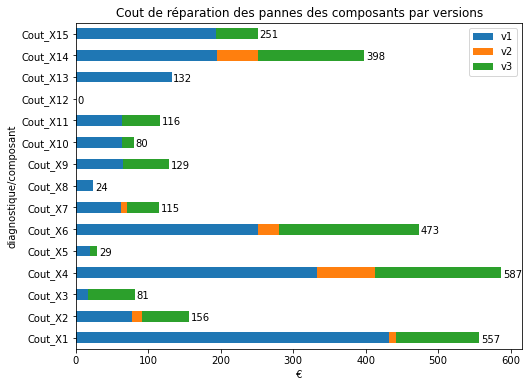

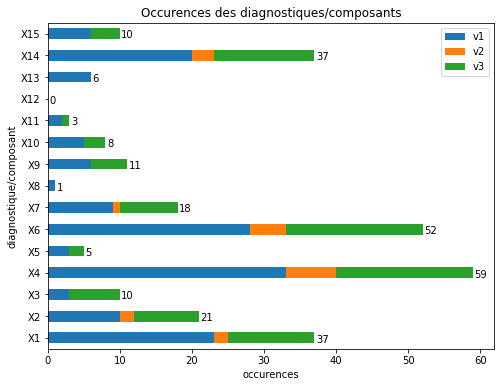

In [41]:
ax_cout_c = df_facteur_cout_c_versions.plot.barh(stacked=True, figsize = (8,6))
for i, v in enumerate(df_facteur_cout_c_versions.sum(axis=1)):
    ax_cout_c.text(v + 2.5, i-0.2 , str(v))
    
ax_cout_c.set_xlabel("€")
ax_cout_c.set_ylabel("diagnostique/composant")
ax_cout_c.set_title("Cout de réparation des pannes des composants par versions")

ax_cout_f = df_facteur_cout_f_versions.plot.barh(stacked=True, figsize = (8,6))
for i, v in enumerate(df_facteur_cout_f_versions.sum(axis=1)):
    ax_cout_f.text(v + 0.2, i-0.2 , str(v))
    
ax_cout_f.set_xlabel("occurences")
ax_cout_f.set_ylabel("diagnostique/composant")
ax_cout_f.set_title("Occurences des diagnostiques/composants")

Ces deux graphiques nous permettent de voir le nombre d'occurence ainsi que le coût de réparation pour chaque diagnostique (avec une petite précision pour différencier les différentes versions). On remarque que X6 et X4 semblent être les premiers qui sortent. On peut essayer de combiner les graphiques suivants en s'intéréssant au cout par occurence.

In [42]:
valeur_v1 = []
valeur_v2 = []
valeur_v3 = []

n_row = df_facteur_cout_c_versions.shape[0]

for j in range(n_row):
    if df_facteur_cout_c_versions['v1'][j] > 0:
        valeur_v1.append(df_facteur_cout_c_versions['v1'][j]/df_facteur_cout_f_versions['v1'][j])
    else :
        valeur_v1.append(0)
    if df_facteur_cout_c_versions['v2'][j] > 0:  
        valeur_v2.append(df_facteur_cout_c_versions['v2'][j]/df_facteur_cout_f_versions['v2'][j])
    else :
        valeur_v2.append(0)
    if df_facteur_cout_c_versions['v3'][j] > 0:  
        valeur_v3.append(df_facteur_cout_c_versions['v3'][j]/df_facteur_cout_f_versions['v3'][j])
    else :
        valeur_v3.append(0)

In [43]:
df_ratio_cout_facteur = pd.DataFrame({'v1': valeur_v1, 'v2': valeur_v2, 'v3': valeur_v3}, index = liste_compo)

df_ratio_cout_facteur = df_ratio_cout_facteur.apply(np.round) 
df_ratio_cout_facteur = df_ratio_cout_facteur.astype(int)

In [44]:
df_ratio_cout_facteur.head()

,v1,v2,v3
X1,19,5,10
X2,8,6,7
X3,5,0,9
X4,10,11,9
X5,7,0,4


Text(0.5, 1.0, 'Cout moyen des pannes des composants par versions')

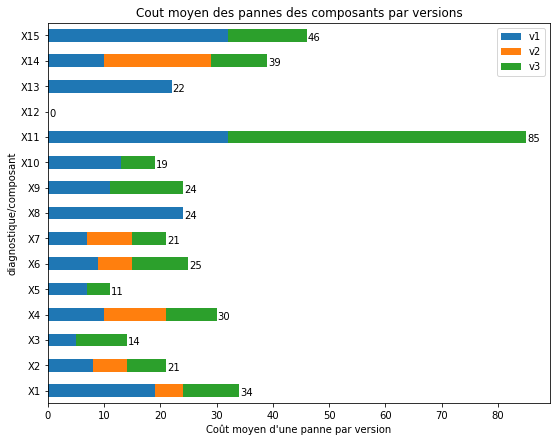

In [45]:
ax_ratio_cout_facteur = df_ratio_cout_facteur.plot.barh(stacked=True, figsize = (9,7))
for i, v in enumerate(df_ratio_cout_facteur.sum(axis=1)):
    ax_ratio_cout_facteur.text(v + 0.2, i-0.2 , str(v))
    
ax_ratio_cout_facteur.set_xlabel("Coût moyen d'une panne par version")
ax_ratio_cout_facteur.set_ylabel("diagnostique/composant")
ax_ratio_cout_facteur.set_title("Cout moyen des pannes des composants par versions")

les chiffres en bout de plot représente la somme des coûts moyens pour chaque diagnostique/composant.

Ce dernier graphique est déjà plus intéréssant. En effet jusqu'à présent on avait un problème car on ne connaissait pas le nombre de pièces totales par version donc compliqué de dire si une version était plus problématique qu'une autre. Ici on a normalisé par les occurences donc ce problème disparaît et surtout comme c'est nous qui nous chargeons des réparations, ce que l'on souhaite minimiser c'est le cout moyen de la panne. En effet on saura que si on un élément k est susceptible de se casser, alors on aura une somme à payer en réparation donc on va chercher à minimiser celle qui en cassant vont nous coûter le plus chère en réparation.    
On voit aussi que notre podium à changer en effet ici les deux composants de tête semblent être X11 et X15 !

### petite pause
Prenons un peu de recul sur ce que nous avons fais jusque-là !    
On rappelle que ce que souhaite le fabricant c'est d'identifier les composants les plus impactants pour les pannes. On a décider de voir impactant sous trois formes :    
- La première forme est l'occurence d'un composant dans une panne    
   => Cette forme semble assez naturelle car quand on revoit passer plusieurs fois un composant on peut se dire qu'il y'a un problème   
- La seconde forme est le coût de réparation    
    => En effet voir plusieurs fois un composant passer dans l'atelier peut montrer un problème mais si le coût de réparation est infime, on peut le néglier. Là où si on a un coût assez élevé, quand on le voit passer plusieurs fois, la facture grimpe vite.     
- La troisième forme est le ratio cout/occurence.     
    => Par cette méthode on a cherché à synthétiser les deux précédentes méthodes tout en se débarassant d'un gros problème : le nombre d'éléments. En effet comme on a pas le nombre total de v1,v2,v3 les occurences sont biaisée. cette méthode semble donc un peu plus juste et elle change les résultats.

### II.1.1) recherche de modèle occurence-cout totale 

On peut commencer à se demander s'il existe une relation entre les occurences des pannes de composants ainsi que le coût total de réparation d'un composant.

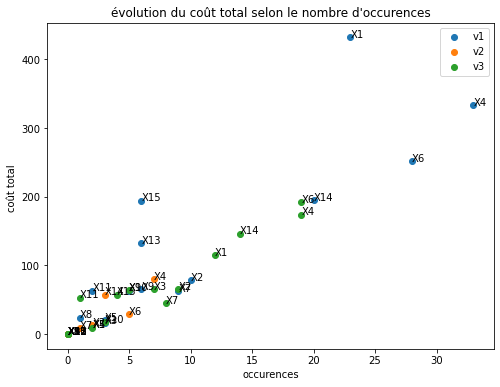

In [46]:
fig,ax = plt.subplots(figsize=(8,6))
for i in range(3):
    plt.scatter(df_facteur_cout_f_versions['v{}'.format(i+1)].values,
                df_facteur_cout_c_versions['v{}'.format(i+1)].values,
                label = 'v{}'.format(i+1))

for ver in facteur['Version'].unique():
    for i, txt in enumerate(liste_compo):
        ax.annotate(txt, (df_facteur_cout_f_versions[ver][i], df_facteur_cout_c_versions[ver][i]))
    
plt.xlabel("occurences")
plt.title("évolution du coût total selon le nombre d'occurences")
plt.ylabel("coût total ")
plt.legend()
plt.show()

Il semble y'avoir une relation linéaire entre le coût et l'occurence même en prenant compte les différentes versions (si on exclue X1 qui possède un coût total beaucoup moins élevé que les autres).

In [47]:
X = pd.concat([df_facteur_cout_f_versions['v1'],df_facteur_cout_f_versions['v2'],df_facteur_cout_f_versions['v3']],
              axis = 0,
              ignore_index = True).values
y = pd.concat([df_facteur_cout_c_versions['v1'],df_facteur_cout_c_versions['v2'],df_facteur_cout_c_versions['v3']],
              axis = 0,
              ignore_index = True).values

In [48]:
X = np.array([[val] for val in X])
y = np.array([[val] for val in y])

reg = LinearRegression()
reg.fit(X, y)

X_predict = reg.predict(X)

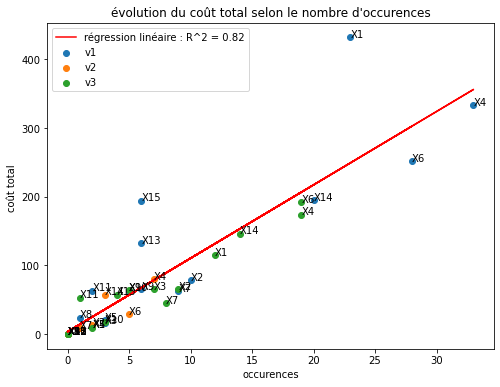

In [49]:
fig,ax = plt.subplots(figsize=(8,6))
for i in range(3):
    plt.scatter(df_facteur_cout_f_versions['v{}'.format(i+1)].values,
                df_facteur_cout_c_versions['v{}'.format(i+1)].values,
                label = 'v{}'.format(i+1))
    
plt.plot(X,X_predict, c = 'r', label = 'régression linéaire : R^2 = {}'.format(np.round(reg.score(X,y),2)))

for ver in facteur['Version'].unique():
    for i, txt in enumerate(liste_compo):
        ax.annotate(txt, (df_facteur_cout_f_versions[ver][i], df_facteur_cout_c_versions[ver][i]))
    
plt.xlabel("occurences")
plt.title("évolution du coût total selon le nombre d'occurences")
plt.ylabel("coût total ")
plt.legend()
plt.show()

Visuellement et avec le $R^{2}$ notre régression linéaire semble adapté. De plus comme on est dans le cas univarié, $R^{2}$ est la  corrélation de l'occurence et du coût total.     
Comme $R^{2} = 0.82$, notre modèle explique 82% de la variance de nos données.    
Toutefois on se hurte au même problème que précédemment : on dit simplement que plus un composant doit être réparer, plus le coût total est élevé. Finalement notre modèle ne nous aide pas.    
Regardons donc le cas où l'on s'intéresse non plus au coût total mais au coût moyen.

### II.1.2) recherche de modèle occurence-coût moyen

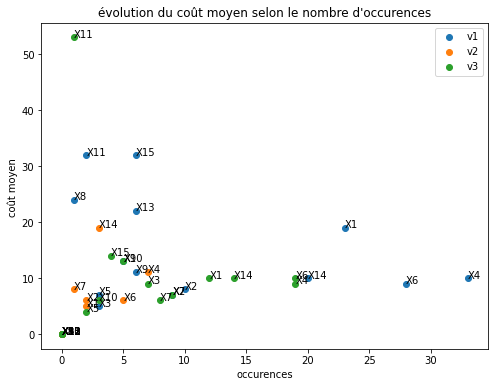

In [50]:
fig,ax = plt.subplots(figsize=(8,6))
for i in range(3):
    plt.scatter(df_facteur_cout_f_versions['v{}'.format(i+1)].values,
                df_ratio_cout_facteur['v{}'.format(i+1)].values,
                label = 'v{}'.format(i+1))

for ver in facteur['Version'].unique():
    for i, txt in enumerate(liste_compo):
        ax.annotate(txt, (df_facteur_cout_f_versions[ver][i], df_ratio_cout_facteur[ver][i]))
    
plt.xlabel("occurences")
plt.title("évolution du coût moyen selon le nombre d'occurences")
plt.ylabel("coût moyen ")
plt.legend()
plt.show()

Malheuresement ici aucun modèle ne semble intéressant à utiliser. On peut simplement dire que comme prévu précédemment, les pannes dû à X11 sont celles qui maximisent le coût moyen par panne donc qu'il serait intéressant de regarder ça.     
Comme quoi, on ne tombe pas toujours sur un modèle.

### II.2)  relation occurence-durée

Comme l'appareil étudié dispose de deux modes de fonctionnement, on peut se demander si on mode de fonctionnement abîme plus les  composants qu'un autre. On va donc chercher à voir s'il existe un lien entre occurence et durée de fonctionnement.    
Comme ici le coût n'a pas d'impact (n'entre pas dans la relation) on va pouvoir utiliser le dataframe facteur qui possède bien plus de données.

In [51]:
test_col_D1 = []
test_col_D2 = []
for val in facteur.columns:
    if ( val == "Version" ) | (val.startswith('X') ):
        test_col_D1.append(val)
        test_col_D2.append(val)
    if (val == 'D1'):
        test_col_D1.append(val)
    if (val == 'D2'):
        test_col_D2.append(val)
        
facteur_D1 = facteur[test_col_D1]
facteur_D2 = facteur[test_col_D2]

# On ne garde que le cas des composants qui ont tournés un minimum dans leur mode respectif
facteur_D1 = facteur_D1[facteur_D1['D1'] > 0]
facteur_D2 = facteur_D2[facteur_D2['D2'] > 0]

In [52]:
facteur_D1.head()

,Version,D1,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,v3,13665.09,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,v2,4888.38,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,v1,10273.96,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0
3,v2,2149.26,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,v3,1.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [53]:
facteur_D2.head()

,Version,D2,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,v3,11751.56,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,v2,3944.48,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
2,v1,13592.97,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0
3,v2,3965.84,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,v3,6.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [54]:
print("On a {} cas de pannes recensés lorsqu'il y'a eu D1".format(facteur_D1.shape[0]))
print("On a {} cas de pannes recensés lorsqu'il y'a eu D2".format(facteur_D2.shape[0]))

On a 440 cas de pannes recensés lorsqu'il y'a eu D1
On a 441 cas de pannes recensés lorsqu'il y'a eu D2


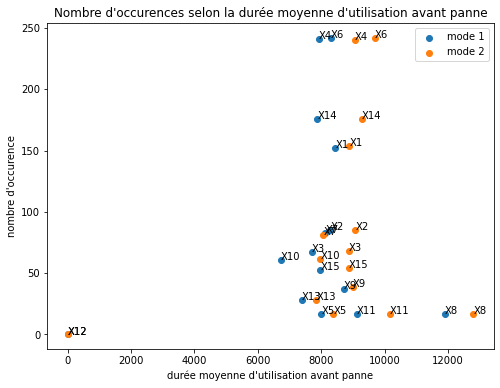

In [55]:
temps_D1 = np.zeros(len(liste_compo))
temps_D2 = np.zeros(len(liste_compo))

for indx in facteur_D1.index:
    for k in range(1,16):
        if(facteur_D1.loc[indx,'X{}'.format(k)] == 1):
            temps_D1[k-1] += facteur_D1.loc[indx,'D1'] 

for indx in facteur_D2.index:
    for k in range(1,16):
        if(facteur_D2.loc[indx,'X{}'.format(k)] == 1):
            temps_D2[k-1] += facteur_D2.loc[indx,'D2']             

            
for k in range(1,16):
    if(k != 12):
        temps_D1[k-1] /= facteur_D1['X{}'.format(k)].sum(axis = 0)
        temps_D2[k-1] /= facteur_D2['X{}'.format(k)].sum(axis = 0)


fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(temps_D1, facteur_D1[liste_compo].sum(axis = 0), label="mode 1")
ax.scatter(temps_D2, facteur_D2[liste_compo].sum(axis = 0), label="mode 2")

# pour que ce soit plus lisible, on va afficher le nom des composants sur le plot
for i, txt in enumerate(liste_compo):
    ax.annotate(txt, (temps_D1[i], facteur_D1[liste_compo].sum(axis = 0)[i]))
    ax.annotate(txt, (temps_D2[i], facteur_D2[liste_compo].sum(axis = 0)[i]))
    
plt.xlabel("durée moyenne d'utilisation avant panne")
plt.title("Nombre d'occurences selon la durée moyenne d'utilisation avant panne")
plt.ylabel("nombre d'occurence")
plt.legend()
plt.show()

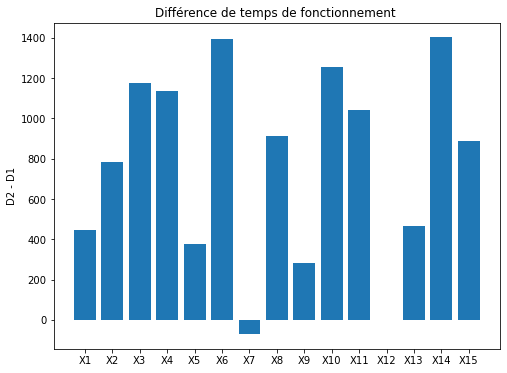

In [56]:
diff_duree_fonctionnement = temps_D2 - temps_D1

plt.subplots(figsize=(8,6))
plt.bar(liste_compo,diff_duree_fonctionnement)
plt.ylabel("D2 - D1")
plt.title("Différence de temps de fonctionnement ")
plt.show()

Ce graphique nous permet de dire que les composants 4 et 6 sont ceux que l'on revoit le plus souvent alors qu'ils n'ont pas été tant utilisés suivis des composants 14 et 1. On peut aussi voir que le mode joue car le mode 1 semble abîmer plus vite les composants et il s'agit d'une tendance générale à l'exception du composant X7.

## Conclusion 

On a pu par l'intermédiaire de différentes techniques, identifier les composants les plus problématiques:     
- En regardant les occurences totales, on a pu voir que les composants **X4**,**X6**,**X14**,**X1** sont les composants qui doivent être réparés le plus souvent et qui impliquent donc un coût total plus élevé que les autres.        

- Après s'être intéressé au ratio coût/occurence, on a pu remarquer que ce sont les composants **X11** (loin devant), **X15**, **X14**,**X1**.        

- En s'intéréssant maintenant aux durées de fonctionnement moyenne avant panne on a pu remarquer que le mode de fonctionnement 1 abîmait plus vite les composants que le 2. Aussi que la plupart des composants s'agglutinent autour de la moyenne de la durée moyenne de fonctionnement avant panne mais qu'il y'a de grands écarts d'occurences. En effet **X4**,**X6**,**X14**,**X1** sont bien plus souvent âbimés et **X11** et **X15** bien moins en étant relativement proche de la même durée de fonctionnement. 

Conseils pour le fabricant :    
- Etant donné le coût moyen élevé de X11, il serait pertinent de voir si on peut réduire ce coût même si le fait qu'on ait peut d'occurences de X11 pourrait signifier qu'il est compliqué d'encore plus le fiabiliser. X15 le serait un peu plus car il semble poser problème plus souvent.
- X4,X6,X14,X1 semblent être les composants à prioritisier si on arrive à réduire les problèmes sur ces composants, on réduirait drastiquement le coût total est "globalement" linéaire par rapport aux occurences, pouvoir diviser le nombre d'occurences par deux (en supposant que ce soit possible) reviendrait à diviser le coût total par deux ce qui est clairement non négligeable. 
- De façon plus générale, il faudrait regarder pourquoi le mode 1 abîme bien plus les composants. Si on comprendre pourquoi (voir la mécanique de l'appareil sur lequel on travaille) on pourrait augmenter la durée de vie des composants (et peut-être espérer que cela soit plus grand que la durée de la garantie afin de ne rien réparer nous-même). 

Bien sûr cela n'est valable que dans le monde où nos hypothèses sont vraies. L'hypothèse de l'uniformité des coûts de réparation des composants pour chaque panne est peut-être un peu forte, il faudrait pouvoir parler avec le fabricant pour avoir plus d'informations et affiner notre modèle. Ne pas connaître le nombre de versions totales produites est aussi problématique car pour la fiabiltié on ne sait trop dire si une version est forcément meilleure qu'une autre.